# Download data

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip -q DIV2K_train_HR.zip 
!mv DIV2K_train_HR train_hr

--2020-12-13 13:03:39--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2020-12-13 13:03:39--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  25.8MB/s    in 2m 14s  

2020-12-13 13:05:53 (25.1 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



# Show some images and crappify them

In [ ]:
import os
from pathlib import Path

base_path = Path(os.getcwd())
data_path = base_path/"train_hr"

In [ ]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

def read_img(index):
    img = plt.imread(data_path/f"{index:04d}.png")
    return img

def show_img(img):
    plt.figure(figsize=(16,9))
    plt.imshow(img)
    plt.show()

In [ ]:
img = read_img(100)

In [ ]:
img.shape

(1356, 2040, 3)

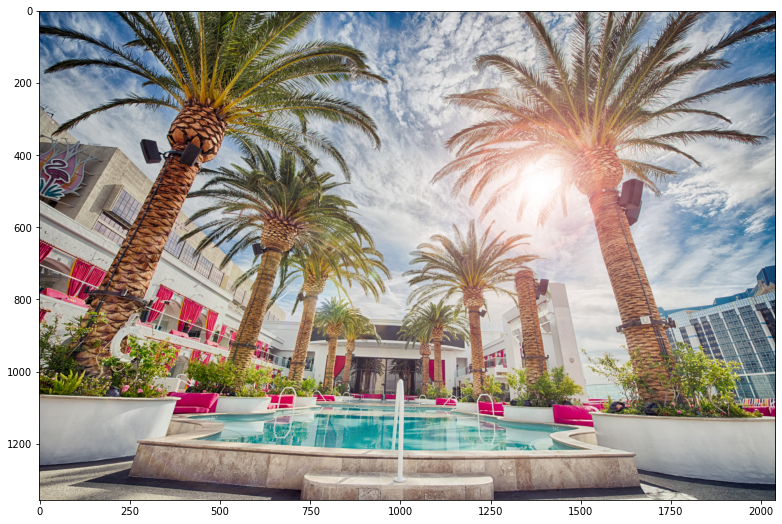

In [ ]:
show_img(read_img(3))

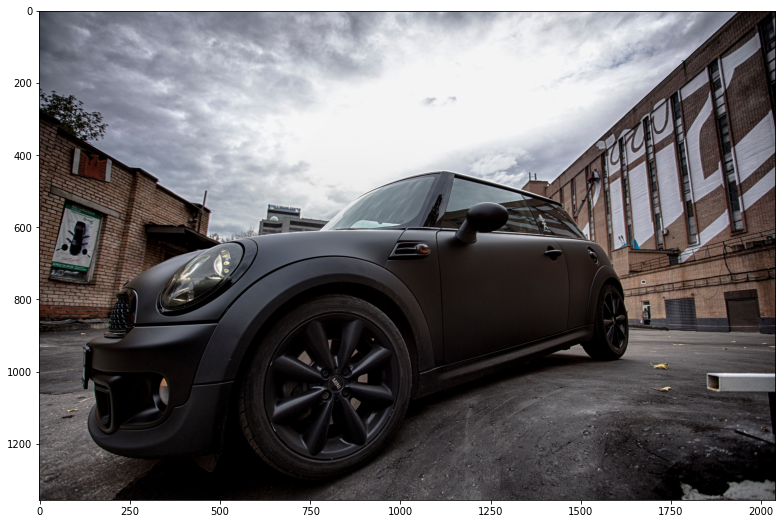

In [ ]:
show_img(read_img(100))

(113, 170, 3)


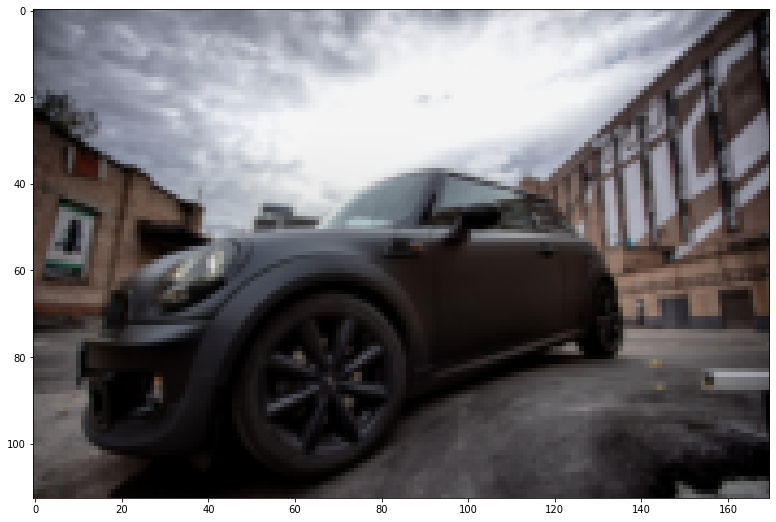

In [ ]:
from skimage.transform import resize
h_crap = 339 // 3
w_crap = 510 // 3
def crappify(img, downsampling_factor=4, target_shape=(h_crap, w_crap, 3)):
    if target_shape is None:
        return resize(img, (img.shape[0] // 4, img.shape[1] // 4, 3),
                      anti_aliasing=True)
    return resize(img, target_shape, anti_aliasing=True)

img = read_img(100)
img = crappify(img)
print(img.shape)
show_img(img)

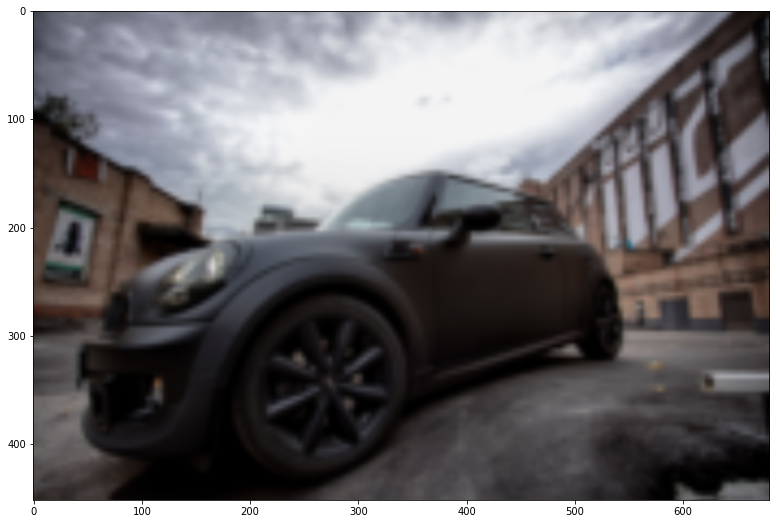

In [ ]:
def decrappify(img, target_shape=(h_crap*4, w_crap*4, 3)):
    return resize(img, target_shape, anti_aliasing=True)

img = decrappify(img)
show_img(img)


In [ ]:
img = read_img(100)

In [ ]:
def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))

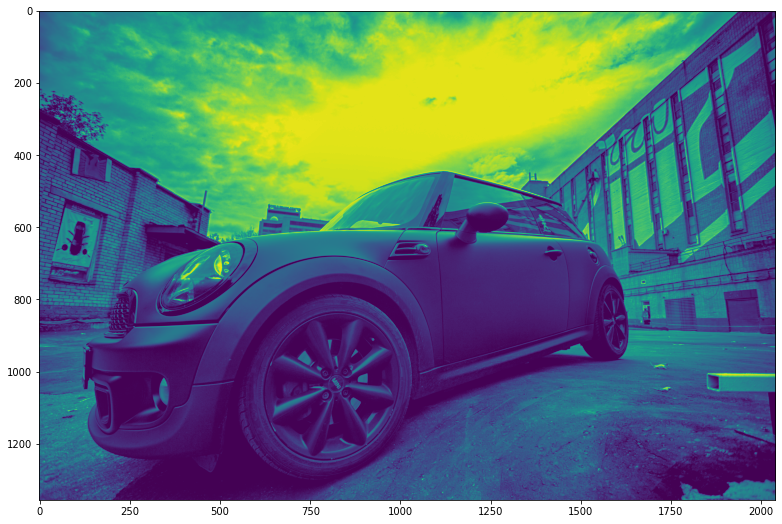

(1356, 2040)

In [ ]:
show_img(convert_rgb_to_y(img))

convert_rgb_to_y(img).shape

In [ ]:
def get_crappified_img(i,target_shape=(h_crap, w_crap, 3), detarget_shape=(h_crap*4, w_crap*4, 3), ycbcr=False):
    img = read_img(i)
    img = crappify(img, target_shape=target_shape)
    img = decrappify(img, target_shape=detarget_shape)
    if ycbcr:
        img = convert_rgb_to_y(img)
    return img

from joblib import Parallel, delayed
def get_crappified(target_shape=(h_crap, w_crap, 3), detarget_shape=(h_crap*4, w_crap*4, 3)):
    return np.array([get_crappified_img(i, target_shape, detarget_shape) 
                    for i in tqdm(range(1, 801))])

#crappified = get_crappified()

In [ ]:
crappified.shape

(800, 452, 680)

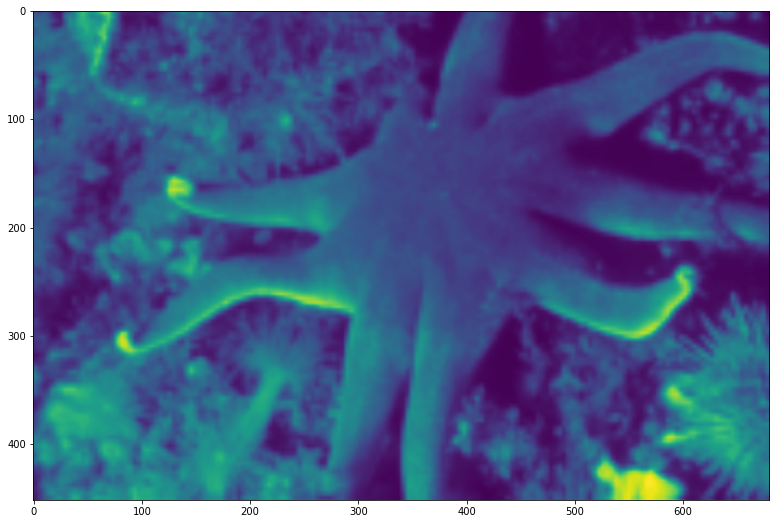

In [ ]:
show_img(crappified[0])

In [ ]:
with open("train_lr.npy", "wb") as f:
    np.save(f, crappified)

In [ ]:
import gc
del crappified
gc.collect()

12472

In [ ]:
def get_crappified_hr_img(i, detarget_shape=(h_crap*4, w_crap*4, 3), ycbcr=False):
    img = read_img(i)
    img = decrappify(img, target_shape=detarget_shape)
    if ycbcr:
        img = convert_rgb_to_y(img)
    return img
   
def get_crappified_hr(detarget_shape=(h_crap*4, w_crap*4, 3)):
    return np.array([get_crappified_hr_img(i,detarget_shape) 
                    for i in tqdm(range(1, 801))])

# crappified_hr = get_crappified_hr()

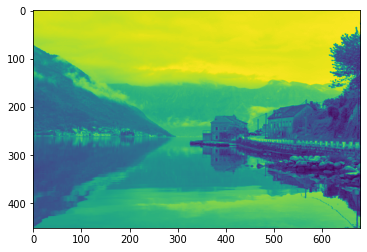

In [ ]:
plt.imshow(crappified_hr[3])

In [ ]:
with open("train_hr.npy", "wb") as f:
    np.save(f, crappified_hr)

In [ ]:
import gc
del crappified_hr
gc.collect()

105

# Kinda train SRCNN

In [ ]:
import torch
from torch.utils.data import Dataset

class TrainDataset(Dataset):
    def __init__(self):
        super(TrainDataset, self).__init__()
        with open("train_hr.npy", "rb") as f:
            self.imgs_hr = np.load(f)[:700]
        with open("train_lr.npy", "rb") as f:
            self.imgs_lr = np.load(f)[:700]
    
    def __getitem__(self, idx):
        return (np.expand_dims(self.imgs_lr[idx] / 255, 0), np.expand_dims(self.imgs_hr[idx] / 255, 0))
    
    def __len__(self):
        return self.imgs_hr.shape[0]

class EvalDataset(Dataset):
    def __init__(self):
        super(EvalDataset, self).__init__()
        with open("train_hr.npy", "rb") as f:
            self.imgs_hr = np.load(f)[700:]
        with open("train_lr.npy", "rb") as f:
            self.imgs_lr = np.load(f)[700:]
    
    def __getitem__(self, idx):
        return (np.expand_dims(self.imgs_lr[idx] / 255, 0), np.expand_dims(self.imgs_hr[idx] / 255, 0))
    
    def __len__(self):
        return self.imgs_hr.shape[0]

In [ ]:
from torch import nn
from torch.nn import functional as F
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(9, 9), stride=1, padding=(3, 3))
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(5, 5), stride=1, padding=(3, 3))
        self.conv3 = nn.Conv2d(32, 1, kernel_size=(5, 5), stride=1, padding=(2, 2))
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
srcnn = SRCNN().cuda()
srcnn

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [ ]:
BS = 16
LR = 1e-4

In [ ]:
from torch.utils.data.dataloader import DataLoader
train_dataset = TrainDataset()
train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BS,
                                shuffle=True,
                                pin_memory=True,
                                drop_last=True)

eval_dataset = EvalDataset()
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

In [ ]:
from torch import optim

optimizer = optim.Adam([
        {'params': srcnn.conv1.parameters()},
        {'params': srcnn.conv2.parameters()},
        {'params': srcnn.conv3.parameters(), 'lr': LR * 0.1}
    ], lr=LR)
criterion = nn.MSELoss()

In [ ]:
def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import copy

best_epoch = 0
best_psnr = 0.0

epochs = 250

for epoch in tqdm(range(epochs)):
    srcnn.train()
    running_loss = 0.0

    for data in train_dataloader:
        optimizer.zero_grad()

        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()


        # forward + backward + optimize
        outputs = srcnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.detach().item()
    
    srcnn.eval()
    epoch_psnr = AverageMeter()

    for data in train_dataloader:
        optimizer.zero_grad()

        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            preds = srcnn(inputs).clamp(0.0, 1.0)

        epoch_psnr.update(calc_psnr(preds, labels), len(inputs))



    print(f'eval psnr: {epoch_psnr.avg}, train_loss: {running_loss / len(train_dataloader)}')

    if epoch_psnr.avg > best_psnr:
        best_epoch = epoch
        best_psnr = epoch_psnr.avg
        best_weights = copy.deepcopy(srcnn.state_dict())


print('Finished Training')
print(f"best epoch: {best_epoch}, best_psnr: {best_psnr}")

eval psnr: 61.17134094238281, train_loss: 1.0017862622547443e-06
eval psnr: 63.37275695800781, train_loss: 5.996763547955197e-07
eval psnr: 65.1353759765625, train_loss: 3.7374791798906384e-07
eval psnr: 66.19637298583984, train_loss: 2.7024801712223266e-07
eval psnr: 66.72883605957031, train_loss: 2.2603434700179837e-07
eval psnr: 67.3188705444336, train_loss: 2.008037481203267e-07
eval psnr: 67.67355346679688, train_loss: 1.7844499277702578e-07
eval psnr: 67.94390106201172, train_loss: 1.6644981289922473e-07
eval psnr: 68.14176940917969, train_loss: 1.571970497130932e-07
eval psnr: 68.30021667480469, train_loss: 1.523516337376646e-07
eval psnr: 68.4593276977539, train_loss: 1.4559479005361767e-07
eval psnr: 68.5296401977539, train_loss: 1.4250378373966416e-07
eval psnr: 68.61370086669922, train_loss: 1.3974757756164594e-07
eval psnr: 68.65277099609375, train_loss: 1.392180424482133e-07
eval psnr: 68.7215347290039, train_loss: 1.380396347512096e-07
eval psnr: 68.55888366699219, train_

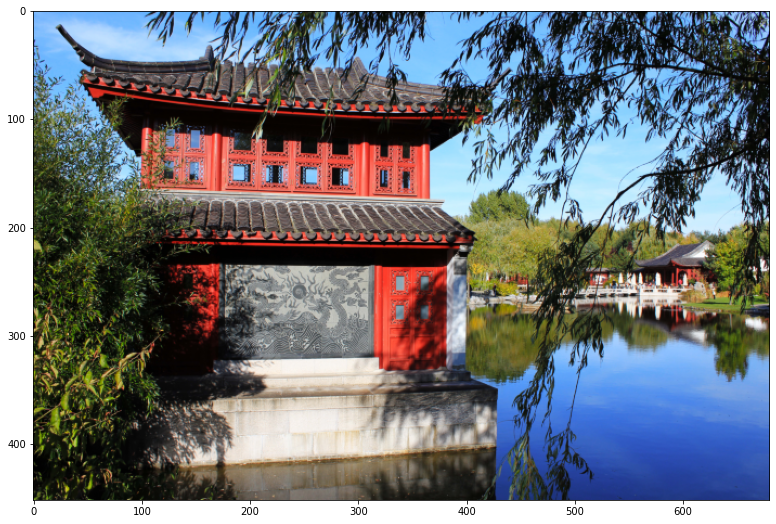

In [ ]:
show_img((imgs_hr_eval[0] * 255).cpu().numpy().swapaxes(0, 2))

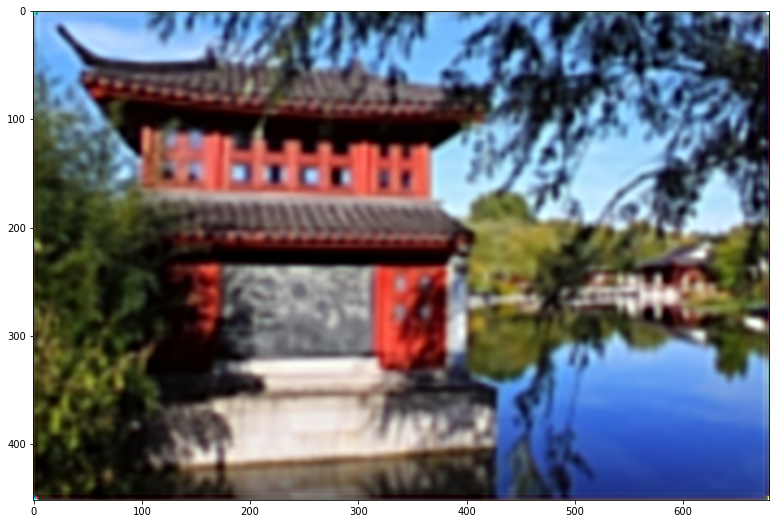

In [ ]:
show_img((srcnn(imgs_lr_eval[0:1])[0] * 255).clip(0., 1.).cpu().detach().numpy().swapaxes(0, 2))

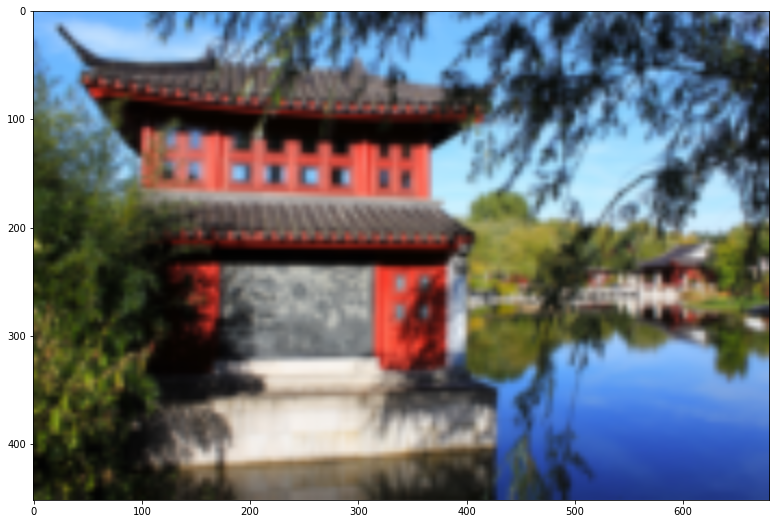

In [ ]:
show_img((imgs_lr_eval[0] * 255).cpu().numpy().swapaxes(0, 2))

In [ ]:
torch.save(srcnn.state_dict(), "srcnn_250_ycbcr.pth")

In [ ]:
# TODO converting rgb to ycbcr
# TODO write dataclass type
# TODO watch into https://github.com/yjn870/SRCNN-pytorch more 
# TODO figure out bug with psnr 
# TODO train RUnet

In [ ]:
srcnn = SRCNN()
srcnn.load_state_dict(torch.load("srcnn_x4.pth"))

<All keys matched successfully>

In [ ]:
def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))

def superres(idx):
    img = read_img(idx)

    img_hr = get_crappified_hr_img(idx)
    img_lr = get_crappified_img(idx)

    ycbcr = convert_rgb_to_ycbcr(img_lr)
    y = ycbcr[..., 0]
    y /= 255.
    y = torch.from_numpy(y)
    y = y.unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        preds = srcnn(y).clamp(0., 1.)
    psnr = calc_psnr(y, preds)
    print('PSNR: {:.2f}'.format(psnr))

    with torch.no_grad():
        preds = preds.numpy().squeeze(0).squeeze(0)
    output = np.array([preds * 255., ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
    output = convert_ycbcr_to_rgb(output)
    print(output)
    return img_hr, img_lr, output.astype(np.uint8)

img_hr, img_lr, img_sr = superres(701)

PSNR: 44.08
[[[-18.831757   -18.587662   -18.314941  ]
  [-17.940292   -17.694763   -17.420776  ]
  [-18.67807    -18.43254    -18.158539  ]
  ...
  [-18.737411   -18.612228   -18.435913  ]
  [-18.737411   -18.612228   -18.435913  ]
  [-18.730759   -18.61406    -18.443909  ]]

 [[-18.829453   -18.588104   -18.318695  ]
  [ -9.269501    -9.027359    -8.757202  ]
  [  7.2674713    7.509613     7.779785  ]
  ...
  [ -6.526428    -6.3944397   -6.2168884 ]
  [-17.666534   -17.53453    -17.356995  ]
  [-18.734543   -18.613419   -18.437317  ]]

 [[-10.94072    -10.699371   -10.429962  ]
  [  1.469635     1.7117767    1.9819336 ]
  [ 25.064026    25.306168    25.576355  ]
  ...
  [  2.924179     3.0561829    3.2337341 ]
  [-18.696487   -18.564484   -18.386932  ]
  [-18.734543   -18.613419   -18.437317  ]]

 ...

 [[-12.633041   -12.592514   -12.756287  ]
  [  5.0261383    5.071518     4.8935547 ]
  [ 20.744278    20.789665    20.611725  ]
  ...
  [ 11.114105    11.213959    11.50827   ]
  [ -6

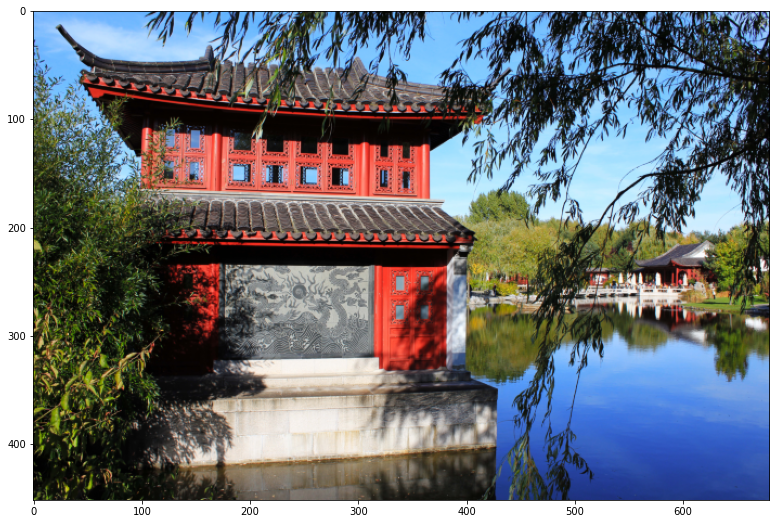

In [ ]:
show_img(img_hr)

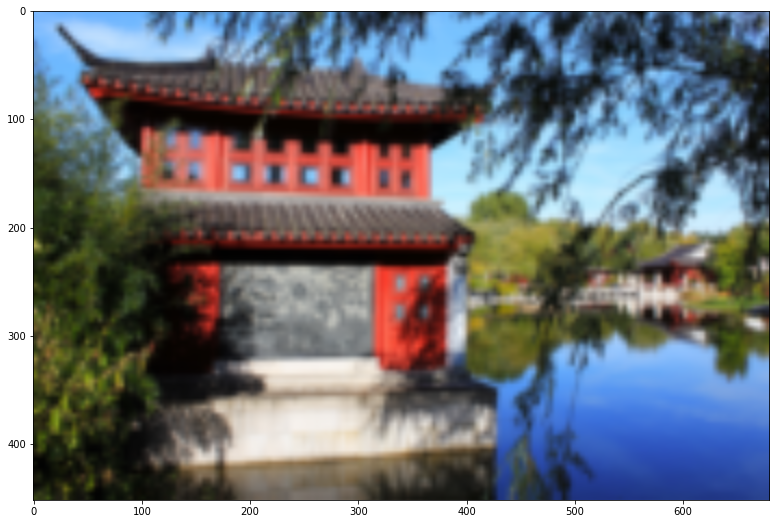

In [ ]:
show_img(img_lr)

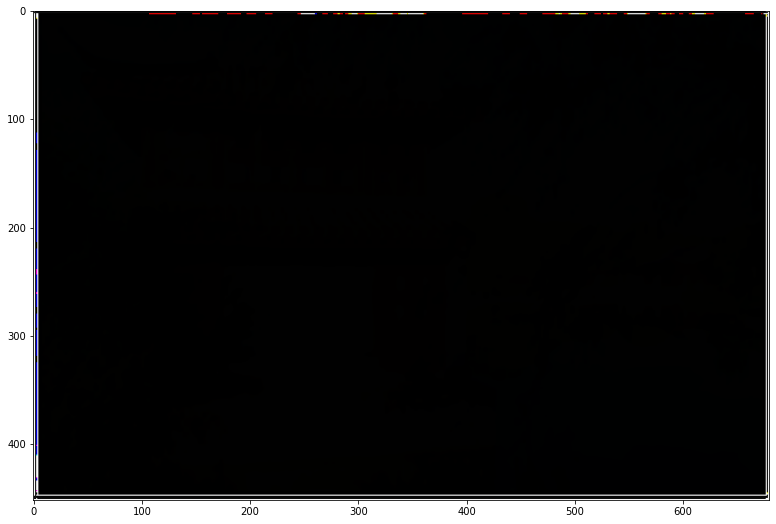

In [ ]:
show_img(img_sr)

In [ ]:
img_sr.shape

(452, 680, 3)

In [ ]:
img_hr.shape

(452, 680, 3)